[Taichi] Starting on arch=cuda


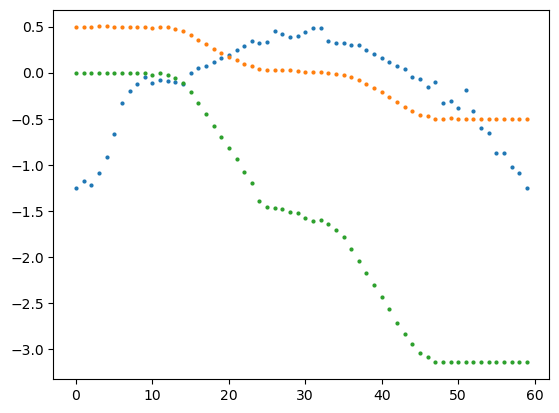

In [51]:
import numpy as np
# from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import taichi as ti
from utils import get_sofa, monotonicly_interpolate
from PIL import Image
# from IPython.display import display

ti.init(arch=ti.gpu)

# xs, ys, rotations = np.load('../trajectory/双拐角_offset2.0/sofa_488.npy')
# xs, ys, rotations = np.load('../trajectory/双拐角_offset1/sofa_3394.npy')
xs, ys, rotations = np.load('../trajectory/180°拐角/sofa_1302.npy')

# 数据点
plt.plot(xs, 'o', markersize=2)
plt.plot(ys, 'o', markersize=2)
plt.plot(rotations, 'o', markersize=2)

# 插值结果
# plt.plot(zoom(xs, zoom=101, order=1))
# plt.plot(zoom(ys, zoom=101, order=1))
# plt.plot(zoom(rotations, zoom=101, order=1))

In [3]:
np.min(rotations) / np.pi

-0.18763349929318296

In [4]:
np.min(ys), np.max(ys)

(-0.5013455347971678, 0.5010212427014039)

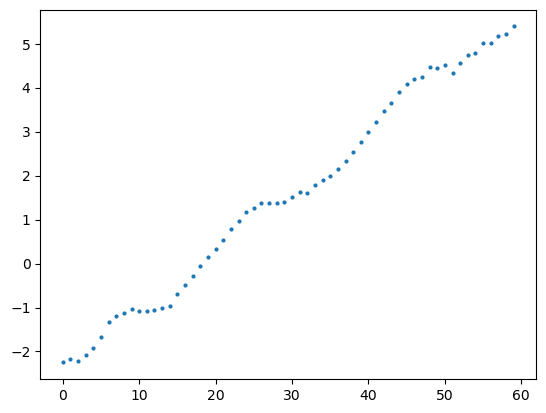

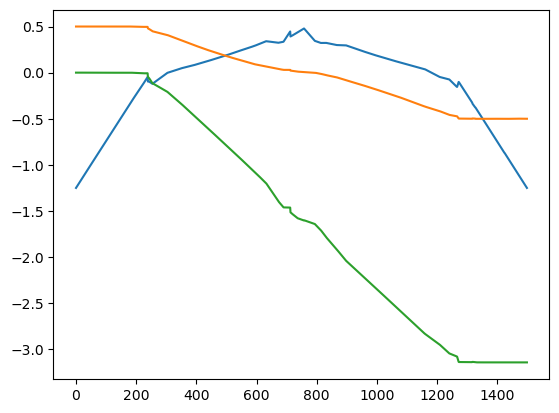

In [52]:
def key_function(xs, ys, rotations):  # 要求这个函数单调递增来重新采样
    # keys = xs - ys - rotations * 0.5
    # keys = xs - ys
    # return xs - ys - (ys + 0.5) * rotations * 0.3  # 适配双拐角沙发（offset = 2）
    # return xs - ys - (ys + 0) * rotations * 0.4  # 适配双拐角沙发（offset = 1）
    return -rotations * 1 - ys * 1 + np.sign(np.pi / 2 + rotations + ys) * (xs - 0.5) * 1

keys = key_function(xs, ys, rotations)
plt.plot(keys, 'o', markersize=2)
plt.show()

xs_monotonic, ys_monotonic, rotations_monotonic = monotonicly_interpolate(
    keys,
    np.array([xs, ys, rotations]).T,
    1500,
    key_min=keys[0],
    key_max=keys[-1]
).T
plt.plot(xs_monotonic)
plt.plot(ys_monotonic)
plt.plot(rotations_monotonic)

Area = 1.7660200109455546


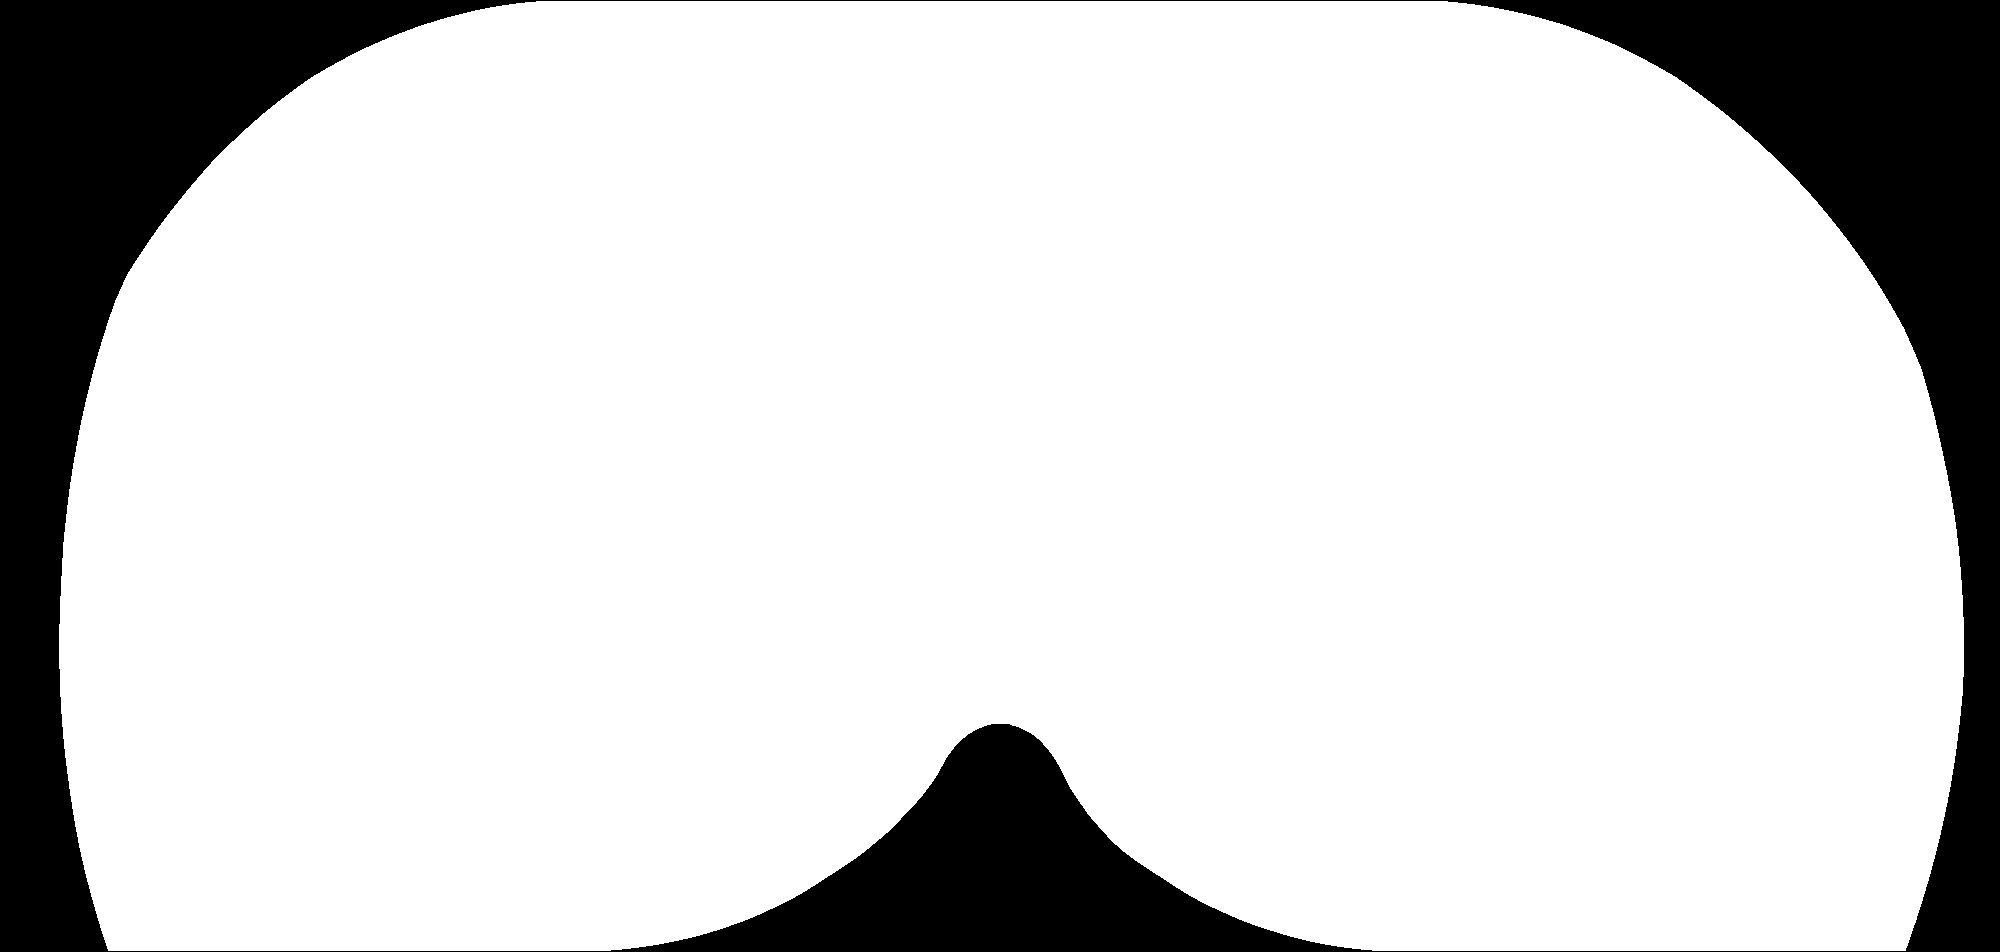

In [58]:
offset = 1

# @ti.func
# def is_forbidden(x, y):  # 指定哪里是墙（双拐角）
#     return y < -offset or y > 1 or (x < 0.0 and y < 0.0) or (x > 1.0 and y > -offset + 1.0)

@ti.func
def is_forbidden(x1, y1, x2, y2):  # 指定哪里是墙（180°拐角）
    return y2 < -1 or y2 > 1 or x2 > 1 or (x2 < 0 and y1 * y2 < 0)  # 括号里的内容制定了无穷薄但不能穿过的墙

# sofa, survive_mask = get_sofa(is_forbidden, xs, ys, rotations, resolution=2000, trajectory_upsampling=101, return_hitting_time=True)
sofa, survive_mask = get_sofa(
    is_forbidden, xs_monotonic, ys_monotonic, rotations_monotonic, resolution=2000,
    sofa_w=2.1, sofa_h=1,
    trajectory_upsampling=1, return_hitting_time=True)
print(f'Area = {np.sum(sofa) / min(*sofa.shape) ** 2}')

image = Image.fromarray(np.array(sofa.T[::-1] * 255, dtype=np.uint8))
image

In [ ]:
# # 渲染单个沙发经过拐角的动画

# from tqdm.notebook import tqdm
# import os
# from PIL import ImageDraw
# from animation_tools import generate_animated_sofa, draw_sofa

# offset = 1

# @ti.func
# def is_forbidden(x, y):  # 指定哪里是墙。双拐角
#     return y < -offset or y > 1 or (x < 0.0 and y < 0.0) or (x > 1.0 and y > -offset + 1.0)

# frames = 150
# sofa = generate_animated_sofa(
#     is_forbidden,
#     'trajectory/双拐角_offset1/sofa_',
#     3394,  # 文件编号
#     0,  # 起始时刻
#     frames,  # 时长
#     int(300 * 3.5 * 2),  # 分辨率
#     draw_text=False
# )

# resolution = (1600, 800)
# scale = 300
# origin = (resolution[0] // 2 - scale // 2, resolution[1] // 2)

# for frame in tqdm(range(frames)):
# # for frame in [75]:
#     rendering_target = Image.new('RGB', resolution, (180, 180, 180))  # 背景
#     draw = ImageDraw.Draw(rendering_target)

#     # 绘制道路
#     line_width = 4
#     draw.polygon([
#             (-10, origin[1] - scale - line_width // 2 - 1),
#             (origin[0] + scale + line_width // 2, origin[1] - scale - line_width // 2 - 1),
#             (origin[0] + scale + line_width // 2, origin[1] - line_width // 2 - 1),
#             (resolution[0] + 10, origin[1] - line_width // 2 - 1),
#             (resolution[0] + 10, origin[1] + scale + line_width // 2),
#             (origin[0] - line_width // 2 - 1, origin[1] + scale + line_width // 2),
#             (origin[0] - line_width // 2 - 1, origin[1] + line_width // 2),
#             (-10, origin[1] + line_width // 2)
#         ], fill=(255, 255, 255), outline=(0, 0, 0), width=line_width)
#     draw.rectangle((origin[0] - line_width // 2, origin[1] - line_width // 2 + 1, origin[0] + line_width // 2 - 2, origin[1] + line_width // 2), fill=(0, 0, 0), width=0)  # 补拐角
#     draw.rectangle((origin[0] + scale - line_width // 2 + 1, origin[1] - line_width // 2 - 1, origin[0] + scale + line_width // 2 - 1, origin[1] + line_width // 2 - 2), fill=(0, 0, 0), width=0)  # 补拐角

#     # 绘制沙发
#     draw_sofa(rendering_target, origin, scale, sofa['image'], sofa['xs'], sofa['ys'], sofa['rotations'], frame - sofa['start_time'])

#     rendering_target.save(f"rendering_results/紧挨的两个拐角/{frame}.png", compress_level=6)

In [70]:
# 适配单拐角沙发
# def id_function(i):
#     # return int(16 * 1.43 ** i - 5 * i - 16)
#     return int(16 * 1.37649 ** i - 5 * i - 16)

# 适配双拐角沙发（offset = 2）
# def id_function(i):
#     return int(14.45 * (1.21 ** i - 1) - 2 * i)

# 适配双拐角沙发（offset = 1）
# def id_function(i):
#     return int(1.5235 * (1.5 ** i - 1) - -1 * i)

# 适配180°拐角沙发
def id_function(i):
    return int(0.5792 * (1.5 ** i - 1) - -1 * i)

[id_function(i) for i in range(20)]

[0,
 1,
 2,
 4,
 6,
 8,
 12,
 16,
 22,
 30,
 42,
 60,
 86,
 125,
 182,
 268,
 395,
 587,
 873,
 1302]

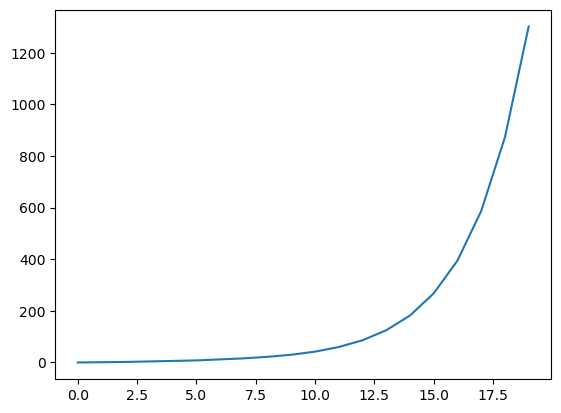

In [71]:
plt.plot([id_function(i) for i in range(20)])

In [77]:
# 渲染若干个沙发依次经过拐角的动画

from PIL import ImageDraw
from tqdm.notebook import tqdm
import os
from animation_tools import draw_sofa, generate_animated_sofa

resolution = (2560, 1440)
# origin = (1250, 550)  # 适配双拐角沙发（offset = 2）
origin = (1250, 550)  # 适配双拐角沙发（offset = 1）
scale = 300
time_scale = 1.0

path = '../trajectory/180°拐角/'
output_path = '../rendering_results/180°拐角/'

# 如果输出路径不存在，构建路径
if not os.path.exists(output_path):
    os.makedirs(output_path)

active_sofas = {}
emit_every_frames = int(90 * time_scale)
for frame in tqdm(range(emit_every_frames * 19 + int((90 + 140) * time_scale))):
# for frame in tqdm(range(100)):
    # 加入新的沙发
    if frame % emit_every_frames == 0:
        id = id_function(frame // emit_every_frames)
        # id = 488
        if os.path.exists(f'{path}sofa_{id}.npy'):
            active_sofas[str(frame // emit_every_frames)] = generate_animated_sofa(
                is_forbidden,
                f'{path}sofa_',
                id,
                frame + int(90 * time_scale),
                int(90 * time_scale),
                int(scale * 3.5 * 2),
                key_function=key_function,  # （适用于双拐角）
                # text_size_factor=0.06  # 文字尺寸（单拐角）
                text_size_factor=0.045,  # 文字尺寸（双拐角）
                # text_color=(0, 0, 0),
                # trajectory_updampling=10
            )

    rendering_target = Image.new('RGB', resolution, (180, 180, 180))  # 背景
    draw = ImageDraw.Draw(rendering_target)

    # 绘制道路（单拐角）
    # line_width = 4
    # draw.polygon([
    #         (-10, origin[1] - scale - line_width // 2 - 1),
    #         (origin[0] + scale + line_width // 2, origin[1] - scale - line_width // 2 - 1),
    #         (origin[0] + scale + line_width // 2, rendering_target.size[1] + 10),
    #         (origin[0] - line_width // 2 - 1, rendering_target.size[1] + 10),
    #         (origin[0] - line_width // 2 - 1, origin[1] + line_width // 2),
    #         (-10, origin[1] + line_width // 2)
    #     ], fill=(255, 255, 255), outline=(0, 0, 0), width=line_width)
    # draw.rectangle((origin[0] - line_width // 2, origin[1] - line_width // 2 + 1, origin[0] + line_width // 2 - 2, origin[1] + line_width // 2), fill=(0, 0, 0), width=0)

    # 绘制道路（双拐角）
    # line_width = 4
    # draw.polygon([
    #         (-10, origin[1] - scale - line_width // 2 - 1),
    #         (origin[0] + scale + line_width // 2, origin[1] - scale - line_width // 2 - 1),
    #         (origin[0] + scale + line_width // 2, origin[1] - scale + scale * offset - line_width // 2 - 1),
    #         (resolution[0] + 10, origin[1] - scale + scale * offset - line_width // 2 - 1),
    #         (resolution[0] + 10, origin[1] + scale * offset + line_width // 2),
    #         (origin[0] - line_width // 2 - 1, origin[1] + scale * offset + line_width // 2),
    #         (origin[0] - line_width // 2 - 1, origin[1] + line_width // 2),
    #         (-10, origin[1] + line_width // 2)
    #     ], fill=(255, 255, 255), outline=(0, 0, 0), width=line_width)
    # draw.rectangle((origin[0] - line_width // 2, origin[1] - line_width // 2 + 1, origin[0] + line_width // 2 - 2, origin[1] + line_width // 2), fill=(0, 0, 0), width=0)  # 补拐角
    # draw.rectangle((origin[0] + scale - line_width // 2 + 1, origin[1] - scale + scale * offset - line_width // 2 - 1, origin[0] + scale + line_width // 2 - 1, origin[1] - scale + scale * offset + line_width // 2 - 2), fill=(0, 0, 0), width=0)  # 补拐角

    # 绘制道路（180°拐角）
    line_width = 4
    draw.polygon([
            (-10, origin[1] - scale - line_width // 2 - 1),
            (origin[0] + scale + line_width // 2, origin[1] - scale - line_width // 2 - 1),
            (origin[0] + scale + line_width // 2, origin[1] + scale + line_width // 2 - 1),
            (-10, origin[1] + scale + line_width // 2 - 1)
        ], fill=(255, 255, 255), outline=(0, 0, 0), width=line_width)

    # 绘制沙发
    for key in list(active_sofas.keys()):
        if frame - active_sofas[key]['start_time'] >= int(140 * time_scale):
            del active_sofas[key]  # 删除已经移出显示区域的沙发
            continue
        draw_sofa(rendering_target, origin, scale, active_sofas[key]['image'], active_sofas[key]['xs'], active_sofas[key]['ys'], active_sofas[key]['rotations'], frame - active_sofas[key]['start_time'])

    draw.line([(-10, origin[1] - 1), (origin[0], origin[1] - 1)], fill=(0, 0, 0), width=line_width)  # 绘制中间的墙（适用于180°拐角）

    rendering_target.save(f"{output_path}{frame}.png", compress_level=6)

    # if frame > 170:
    #     break
    # break
# rendering_target

  0%|          | 0/1940 [00:00<?, ?it/s]

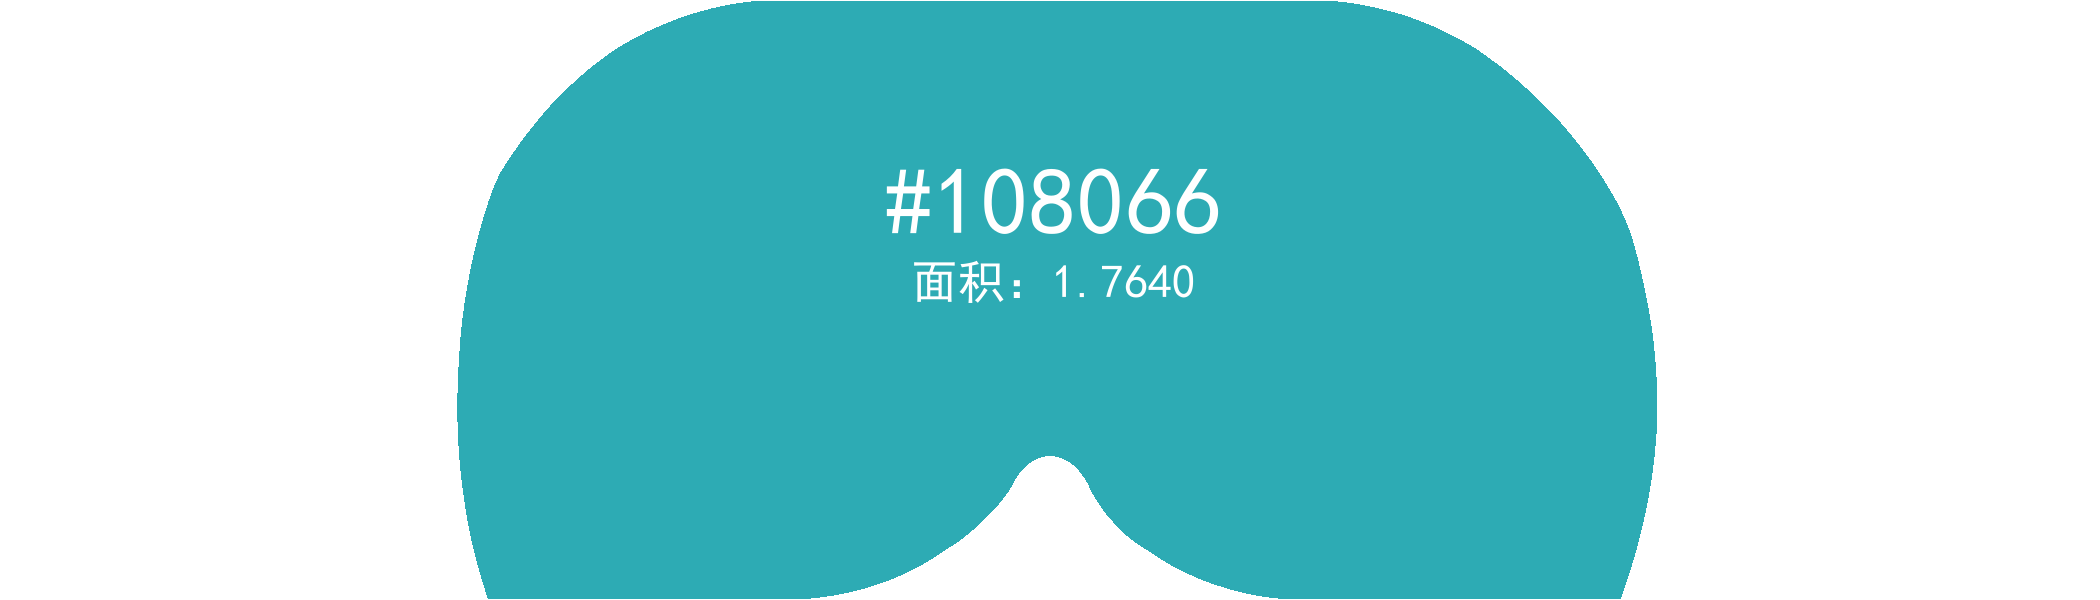

In [78]:
generate_animated_sofa(
    is_forbidden,
    f'{path}sofa_',
    1302,
    frame + int(90 * time_scale),
    int(90 * time_scale),
    int(scale * 3.5 * 2),
    key_function=key_function,  # （适用于双拐角）
    draw_text=True,
    # text_size_factor=0.06  # 文字尺寸（单拐角）
    text_size_factor=0.045,  # 文字尺寸（双拐角）
    # trajectory_updampling=10
)['image']